In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from skimage.metrics import structural_similarity, mean_squared_error

In [13]:
image = cv2.imread('sar_3.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [36]:
# 1. Найти наиболее протяженный участок (линии Хафа)
bin_img = np.copy(image_gray)
threshold_value = 80
bin_img[image_gray < threshold_value] = 0
bin_img[image_gray >= threshold_value] = 255

canny = cv2.Canny(bin_img, 0, 250, apertureSize=3)
lines = cv2.HoughLines(canny, 1, np.pi / 180, threshold=110)

image_with_lines = image.copy()
max_length = 0
longest_line_params = None

if lines is not None:
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        
        pt1_temp = (int(x0 + 2000 * (-b)), int(y0 + 2000 * (a)))
        pt2_temp = (int(x0 - 2000 * (-b)), int(y0 - 2000 * (a)))
        length = math.sqrt((pt2_temp[0] - pt1_temp[0]) ** 2 + (pt2_temp[1] - pt1_temp[1]) ** 2)

        if length > max_length:
            max_length = length
            longest_line_params = (rho, theta)

if longest_line_params is not None:
    rho, theta = longest_line_params
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 2000 * (-b)), int(y0 + 2000 * (a)))
    pt2 = (int(x0 - 2000 * (-b)), int(y0 - 2000 * (a)))
    
    cv2.line(image_with_lines, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
    print(f"Найдена линия длиной: {max_length:.2f} пикселей")

Найдена линия длиной: 3998.89 пикселей


In [37]:
# 2. Исследование алгоритмов бинаризации для выделения дорожной полосы
_, thresh_otsu = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thresh_adaptive = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 51, 10)

road_mask = thresh_adaptive == 0
image_road = image.copy()
image_road[road_mask] = [0, 255, 0]

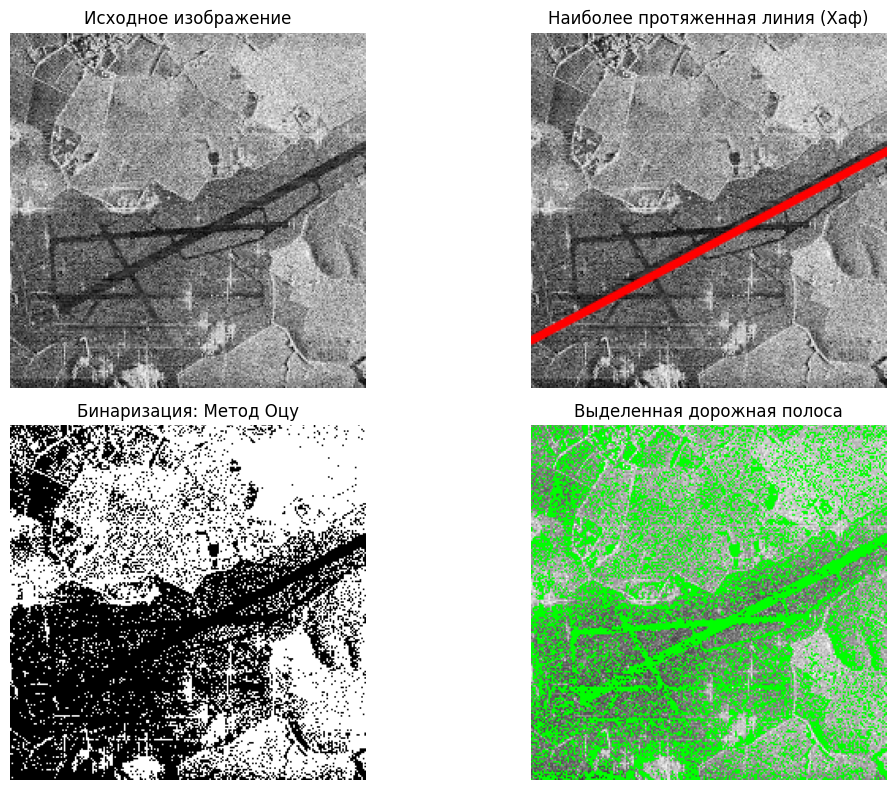

In [38]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title('Наиболее протяженная линия (Хаф)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(thresh_otsu, cmap='gray')
plt.title('Бинаризация: Метод Оцу')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(image_road, cv2.COLOR_BGR2RGB))
plt.title('Выделенная дорожная полоса')
plt.axis('off')

plt.tight_layout()
plt.show()

In [39]:
mse_otsu = mean_squared_error(image_gray, thresh_otsu)
mse_adaptive = mean_squared_error(image_gray, thresh_adaptive)

ssim_otsu = structural_similarity(image_gray, thresh_otsu)
ssim_adaptive = structural_similarity(image_gray, thresh_adaptive)

if ssim_otsu > ssim_adaptive:
    best_method = "Оцу"
    best_ssim = ssim_otsu
else:
    best_method = "Адаптивная"
    best_ssim = ssim_adaptive

print(f"Лучший метод: {best_method} (SSIM={best_ssim:.4f})")

Лучший метод: Адаптивная (SSIM=0.3822)
